# Handling Multicollinearity In Linear Models : An Emperical Evaluation Of PCA And Ridge Regression

### Submitted by :  Sumanth Javvaji - 22EE3FP23

## Loading Necessary Libraries


In [217]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb
import sys
import os
sys.path.append(os.path.abspath('..'))


## Loading the dataset as a dataframe

In [218]:
data = pd.read_csv('Humidity.csv')

## Exploratory Data Analysis

In [219]:
# Cleaining and dealing with missing values in the dataframe
data.replace(-200, np.nan, inplace=True) 
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.head(3)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH
0,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,0.757754
1,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,0.725487
2,2.2,1402.00,88.0,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.9,0.750239


<Axes: >

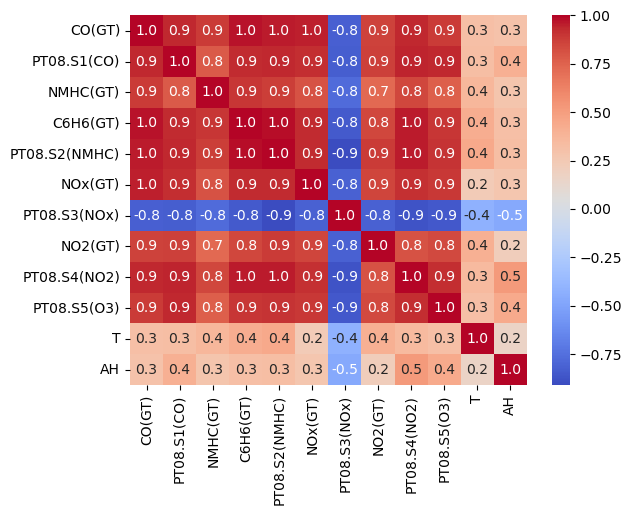

In [220]:
# Heatmap to visualize correlation matrix of dataframe
sb.heatmap(data.corr(), annot=True, fmt='.1f', cmap='coolwarm')

## Helper Functions

We have defined some functions to calculate statistical properties of the sample data.

In [221]:
def manual_skew(x):
    # Compute skewness manually
    n = len(x)
    mean = np.mean(x)
    std = np.std(x, ddof=1)
    return np.sum(((x - mean)/std)**3) * (n / ((n-1)*(n-2)))

def manual_kurtosis(x):
    # Compute excess kurtosis manually
    n = len(x)
    mean = np.mean(x)
    std = np.std(x, ddof=1)
    standardized_moment_4 = np.sum(((x - mean)/std)**4) # 4th standardized moment
    term1 = (n * (n + 1)) / ((n - 1)*(n - 2)*(n - 3)) * standardized_moment_4
    term2 = (3 * (n - 1)**2) / ((n - 2)*(n - 3))
    return term1 - term2  # Excess kurtosis

def gaussian(x, mu, sigma):
    # Compute the value of the Gaussian (normal) distribution at x
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def calculate_vif(X):
    # Calculate Variance Inflation Factor (VIF) for each feature in X
    X = np.asarray(X)
    n_features = X.shape[1]
    vif = []

    for i in range(n_features):
        y = X[:, i]
        X_other = np.delete(X, i, axis=1)
        X_other = np.hstack((np.ones((X_other.shape[0], 1)), X_other))
        beta, residuals, rank, s = np.linalg.lstsq(X_other, y, rcond=None)
        y_pred = X_other @ beta
        ss_total = np.sum((y - np.mean(y))**2)
        ss_res = np.sum((y - y_pred)**2)

        r_squared = 1 - (ss_res / ss_total)
        vif_value = 1 / (1 - r_squared) if r_squared < 1 else float('inf')
        vif.append(vif_value)

    return vif

def frobenius_norm(matrix):
    """
    Calculate the Frobenius norm of a given matrix.

    Parameters:
    matrix (array-like): 2D list or numpy array representing the matrix.

    Returns:
    float: Frobenius norm of the matrix.
    """
    matrix = np.array(matrix)
    return np.sqrt(np.sum(matrix**2))

## Regressors Analysis - Multicollinearity

### Variance Inflation Factor (VIF)

In [222]:
data_cleaned = data.dropna()
X = data_cleaned.select_dtypes(include=[np.number])
vif_values = calculate_vif(X.values)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = vif_values
print(vif_data)

          Feature         VIF
0          CO(GT)   39.124170
1     PT08.S1(CO)   22.005175
2        NMHC(GT)    7.119107
3        C6H6(GT)  155.940732
4   PT08.S2(NMHC)  189.881885
5         NOx(GT)   15.496730
6    PT08.S3(NOx)   19.743372
7         NO2(GT)    7.783276
8    PT08.S4(NO2)   71.342584
9     PT08.S5(O3)   11.550767
10              T    2.305228
11             AH    5.421903


### Correlation Matrix Inspection

In [223]:
for regressor in X.columns:
    print(f"E[{regressor}] = {X[regressor].mean()} and Var[{regressor}] = {X[regressor].var()}") 
    X[regressor] = (X[regressor] - X[regressor].mean()) / np.sqrt(X[regressor].var())

E[CO(GT)] = 2.3535671100362756 and Var[CO(GT)] = 1.9866791489411608
E[PT08.S1(CO)] = 1207.741837968561 and Var[PT08.S1(CO)] = 58480.17822728769
E[NMHC(GT)] = 231.0253929866989 and Var[NMHC(GT)] = 43456.36860381026
E[C6H6(GT)] = 10.772367256060537 and Var[C6H6(GT)] = 55.01377953568389
E[PT08.S2(NMHC)] = 965.9837767029422 and Var[PT08.S2(NMHC)] = 70975.95982694879
E[NOx(GT)] = 143.5018137847642 and Var[NOx(GT)] = 6696.102599611768
E[PT08.S3(NOx)] = 963.1780532043528 and Var[PT08.S3(NOx)] = 70706.08233756927
E[NO2(GT)] = 100.25997581620314 and Var[NO2(GT)] = 991.860902178591
E[PT08.S4(NO2)] = 1600.5065497783153 and Var[PT08.S4(NO2)] = 91379.26565351058
E[PT08.S5(O3)] = 1045.6910519951632 and Var[PT08.S5(O3)] = 160104.23854238124
E[T] = 15.599858936932906 and Var[T] = 23.285978204114066
E[AH] = 0.8318508813478259 and Var[AH] = 0.03186453788431558


In [224]:
# Computing the correlation matrix
gram_matrix = X.T @ X
diag = np.diag(gram_matrix)
stddev = np.sqrt(diag)
normalizer = np.outer(stddev, stddev)
normalizer[normalizer == 0] = 1e-10
correlation_matrix = gram_matrix / normalizer
correlation_matrix

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH
CO(GT),1.000000,0.936258,0.887167,0.972672,0.958444,0.951342,-0.823709,0.861432,0.939922,0.882942,0.318468,0.295589
PT08.S1(CO),0.936258,1.000000,0.781758,0.931404,0.936364,0.922894,-0.829552,0.866574,0.945006,0.935004,0.324937,0.407018
NMHC(GT),0.887167,0.781758,1.000000,0.897971,0.875056,0.811182,-0.774207,0.728052,0.848499,0.761909,0.367081,0.282137
C6H6(GT),0.972672,0.931404,0.897971,1.000000,0.984795,0.927335,-0.848710,0.846740,0.960851,0.896992,0.418266,0.313606
PT08.S2(NMHC),0.958444,0.936364,0.875056,0.984795,1.000000,0.926643,-0.910622,0.885027,0.957882,0.909109,0.445724,0.325284
NOx(GT),0.951342,0.922894,0.811182,0.927335,0.926643,1.000000,-0.814288,0.857425,0.912718,0.893379,0.238500,0.270676
PT08.S3(NOx),-0.823709,-0.829552,-0.774207,-0.848710,-0.910622,-0.814288,1.000000,-0.815213,-0.880199,-0.857531,-0.424083,-0.463007
NO2(GT),0.861432,0.866574,0.728052,0.846740,0.885027,0.857425,-0.815213,1.000000,0.807764,0.839648,0.406911,0.214562
PT08.S4(NO2),0.939922,0.945006,0.848499,0.960851,0.957882,0.912718,-0.880199,0.807764,1.000000,0.918977,0.343745,0.515559
PT08.S5(O3),0.882942,0.935004,0.761909,0.896992,0.909109,0.893379,-0.857531,0.839648,0.918977,1.000000,0.313561,0.440171


### Condition Index and Eigenvalue Decomposition

In [225]:
y = X['AH'] # target variable
X.drop(columns=['AH'], inplace=True)

In [226]:
C = X.T @ X
eig_val = np.linalg.eigvals(C)
eig_val = np.real(eig_val)
lambda_max = np.max(eig_val)
j=0
print(f"\ncondition number: {lambda_max/np.min(eig_val)}\n")
for col in X.columns:
    print(f"condition indices for {col} = {lambda_max / eig_val[j]}")
    j += 1



condition number: 2829.773820719006

condition indices for CO(GT) = 1.0
condition indices for PT08.S1(CO) = 10.160399001877096
condition indices for NMHC(GT) = 27.504259917026584
condition indices for C6H6(GT) = 40.93794881948838
condition indices for PT08.S2(NMHC) = 48.73794269069221
condition indices for NOx(GT) = 97.66283956101586
condition indices for PT08.S3(NOx) = 138.21575287052232
condition indices for NO2(GT) = 2829.773820719006
condition indices for PT08.S4(NO2) = 460.55201340474383
condition indices for PT08.S5(O3) = 335.0904248395389
condition indices for T = 237.4570144998442


## Visualizing the standardized distribution of the features

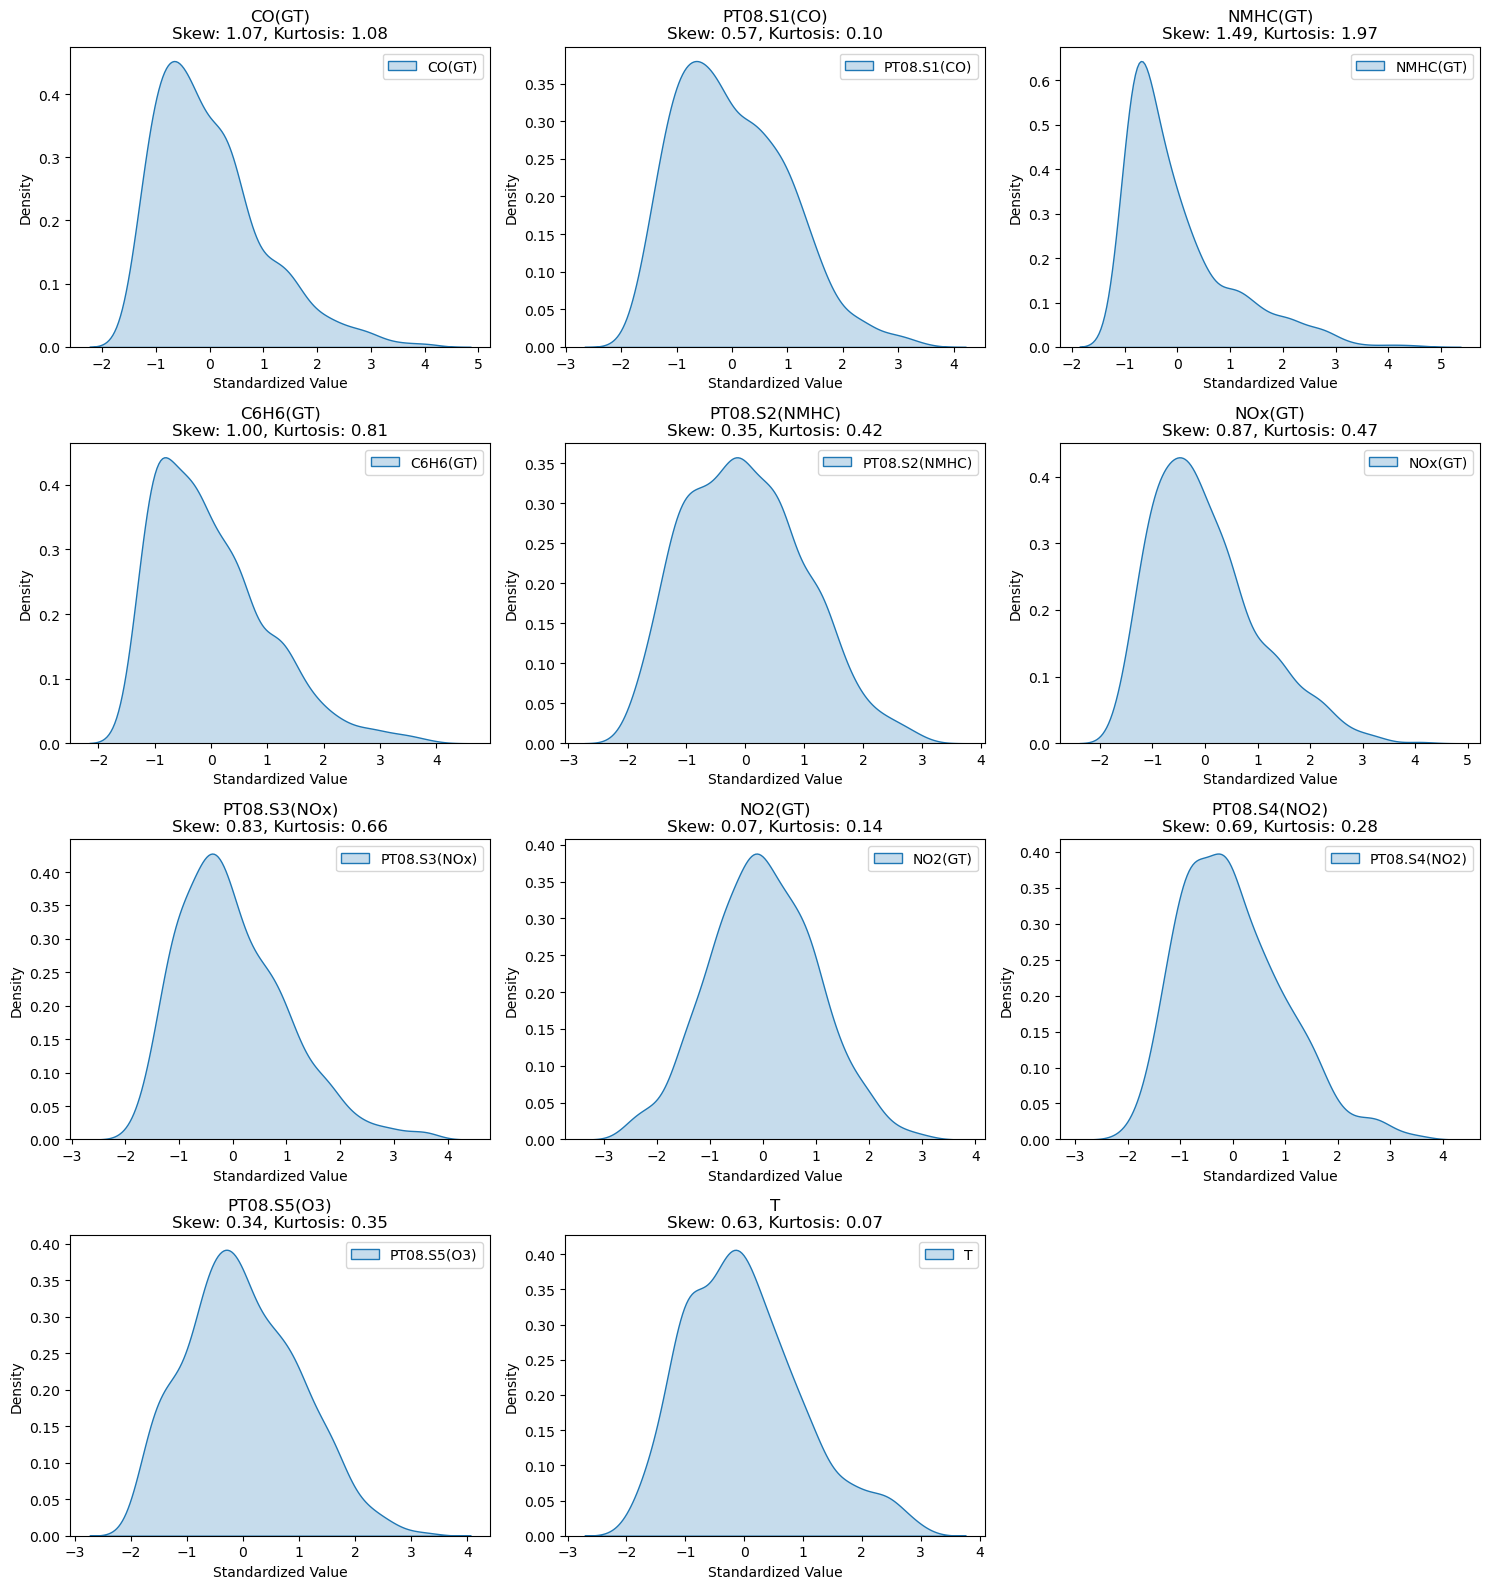

In [227]:
n_cols = 3  
n_rows = int(np.ceil(len(X.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  
for i, regressor in enumerate(X.columns):
    ax = axes[i]
    sb.kdeplot(X[regressor], fill=True, ax=ax, label=regressor)
    ax.set_xlabel('Standardized Value')
    ax.set_ylabel('Density')
    ax.set_title(f'{regressor}\nSkew: {abs(manual_skew(X[regressor])):.2f}, Kurtosis: {abs(manual_kurtosis(X[regressor])):.2f}')
    ax.legend()
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Modelling

### Least Squares Estimate

In [228]:
beta = np.linalg.inv(X.T @ X).dot(X.T @ y)
y_hat = X @ beta
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)

ss_reg = ss_tot - ss_res
n = X.shape[0]
p = X.shape[1] - 1 
df_reg = p
df_res = n - p - 1
df_tot = n - 1

ms_reg = ss_reg / df_reg
ms_res = ss_res / df_res

F = ms_reg / ms_res
r2_score_Ls = 1 - (ss_res / ss_tot)

print(f"R² Score: {r2_score_Ls:.4f}")
print("\nANOVA Table:")
print(f"{'Source':<12}{'SS':>12}{'DF':>8}{'MS':>12}{'F':>10}")
print(f"{'Regression':<12}{ss_reg:12.4f}{df_reg:8}{ms_reg:12.4f}{F:10.4f}")
print(f"{'Residual':<12}{ss_res:12.4f}{df_res:8}{ms_res:12.4f}")
print(f"{'Total':<12}{ss_tot:12.4f}{df_tot:8}")

R² Score: 0.8156

ANOVA Table:
Source                SS      DF          MS         F
Regression      673.6550      10     67.3655  360.8273
Residual        152.3450     816      0.1867
Total           826.0000     826


In [ ]:
print(f"Variance of beta:")
Var_beta = np.var(y)* np.linalg.inv(X.T @ X)
# Var_beta = np.diag(Var_beta) # Variance of each coefficient
print("trace:",np.trace(Var_beta))
print("frobenius norm:",frobenius_norm(Var_beta))
print(Var_beta)

Variance of beta:
[0.04705935 0.02650521 0.00854918 0.18366817 0.19452816 0.01760442
 0.02180434 0.00937784 0.03550271 0.01381403 0.00240427]


### Ridge Estimation

In [230]:
n = X.shape[0]
p = X.shape[1]
k = p * np.var(y) / (beta.T @ beta)
print("Biasing factor k:", k)
I = np.eye(p)
betaR = np.linalg.inv(X.T @ X + k * I).dot(X.T @ y)
y_hat = X @ betaR
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
ss_reg = ss_tot - ss_res
df_reg = p
df_res = n - p
df_tot = n - 1
ms_reg = ss_reg / df_reg
ms_res = ss_res / df_res
F = ms_reg / ms_res
r2_scoreR = 1 - (ss_res / ss_tot)
print(f"\nR² Score (Ridge): {r2_scoreR:.4f}")

print("\nRidge ANOVA Table:")
print(f"{'Source':<12}{'SS':>12}{'DF':>8}{'MS':>12}{'F':>10}")
print(f"{'Regression':<12}{ss_reg:12.4f}{df_reg:8}{ms_reg:12.4f}{F:10.4f}")
print(f"{'Residual':<12}{ss_res:12.4f}{df_res:8}{ms_res:12.4f}")
print(f"{'Total':<12}{ss_tot:12.4f}{df_tot:8}")

Biasing factor k: 0.7588693182551631

R² Score (Ridge): 0.8151

Ridge ANOVA Table:
Source                SS      DF          MS         F
Regression      673.2533      11     61.2048  326.9673
Residual        152.7467     816      0.1872
Total           826.0000     826


In [ ]:
print(f"Variance of betaR:")
XtX = X.T @ X
ridge_inv = np.linalg.inv(XtX + k * I)
var_betaR = np.var(y) * ridge_inv @ XtX @ ridge_inv
# var_betaR = np.diag(var_betaR)
print("trace:",np.trace(var_betaR))
print("frobenius norm:",frobenius_norm(var_betaR))

Variance of betaR:
[0.04174631 0.02424479 0.00813247 0.11574676 0.12373138 0.01686154
 0.01591333 0.00876102 0.03174732 0.01293603 0.00234495]


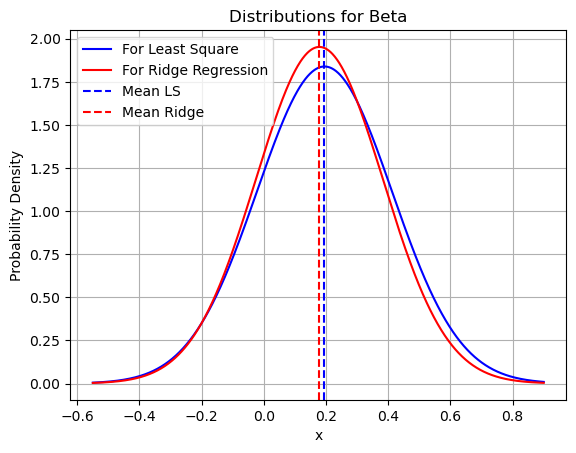

In [232]:
mu1, sigma1 = beta[0], np.sqrt(Var_beta[0])
mu2, sigma2 = betaR[0], np.sqrt(var_betaR[0])
x = np.linspace(-0.55, 0.9, 1000)
y1 = gaussian(x, mu1, sigma1)
y2 = gaussian(x, mu2, sigma2)

plt.plot(x, y1, label='For Least Square', color='blue')
plt.plot(x, y2, label='For Ridge Regression', color='red')

plt.axvline(mu1, color='blue', linestyle='--', label='Mean LS')
plt.axvline(mu2, color='red', linestyle='--', label='Mean Ridge')

plt.title('Distributions for Beta')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


**Plotting functions**

A few functions to plot the results

In [234]:
def plot_beta_distn(beta, betaR, Var_beta, var_betaR, k_solution):
    mu1, sigma1 = beta[0], np.sqrt(Var_beta[0])
    mu2, sigma2 = betaR[0], np.sqrt(var_betaR[0])
    x = np.linspace(-0.55, 0.9, 1000)
    y1 = gaussian(x, mu1, sigma1)
    y2 = gaussian(x, mu2, sigma2)
    
    plt.plot(x, y1, label='For Least Square', color='blue')
    plt.plot(x, y2, label=f'For Ridge Regression \nwith k ={k_solution:0.2f}', color='red')
    
    plt.axvline(mu1, color='blue', linestyle='--', label='Mean LS')
    plt.axvline(mu2, color='red', linestyle='--', label='Mean Ridge')

    plt.title('Distributions for Beta')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

def plot_contour(beta, betaR, k_solution, X, y):
    X2 = X.iloc[:, :2].to_numpy() 
    # Convert y to numpy array
    y = y.to_numpy() if hasattr(y, 'to_numpy') else y

    b1 = np.linspace(-1.5, 1.5, 400)
    b2 = np.linspace(-1.5, 1.5, 400)
    B1, B2 = np.meshgrid(b1, b2)
    
    def compute_rss(beta_vals):
        # Function to compute RSS at arbitrary beta values
        Y_hat = X2 @ beta_vals
        return np.sum((y - Y_hat) ** 2)

    def rss_contour(B1, B2, X2, y):
        # Generate RSS for the grid
        B = np.vstack([B1.ravel(), B2.ravel()])
        Y_hat = X2 @ B
        residuals = y.reshape(-1, 1) - Y_hat
        rss = np.sum(residuals**2, axis=0)
        return rss.reshape(B1.shape)

    RSS = rss_contour(B1, B2, X2, y)

    # Calculate RSS at beta and betaR
    rss_beta = compute_rss(beta[:2])
    rss_betaR = compute_rss(betaR[:2])

# Plot
    plt.figure(figsize=(8, 6))
    contours = plt.contour(B1, B2, RSS, levels=20, cmap='viridis')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.contour(B1, B2, RSS, levels=[rss_beta], colors='black', linestyles='--', linewidths=1.5)
    plt.contour(B1, B2, RSS, levels=[rss_betaR], colors='red', linestyles='--', linewidths=1.5)

    plt.plot(beta[0], beta[1], 'ko', label=r'$\hat{\beta}$ (OLS)')
    plt.plot(betaR[0], betaR[1], 'ro', label=f'For Ridge Regression \nwith k ={k_solution:0.2f}')

# Labels and titles
    plt.xlabel(r'$\beta_1$')
    plt.ylabel(r'$\beta_2$')
    plt.title('Geometric Interpretation of Ridge Regression')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal')
    plt.savefig('For_k1.png', dpi=300)
    plt.show()


**COMPARISON OF METHOD FOR CHOOSING k FOR RIDGE REGRESSION**

We perform the Ridge estimation by employing different methods for choosing the biasing parameter k

In [235]:
var_ridge = {}
r2_ridge = {}

**Method 1 - Hoerl, Kennard, and Baldwin Method**

Hoerl *et al.* suggested choosing $\lambda$ according to the expression:

$$
\lambda = \frac{p \cdot \sigma^2}{\beta^\top \beta}
$$

where:

- *p* is the number of predictors,  
- $\beta$ and $\sigma^2$ are derived from the ordinary least squares (OLS) solution.
$

In [ ]:
p =X.shape[1]
k = p * np.var(y)/ (beta.T @ beta)
print("biasing factor k:", k)
I = np.eye(X.shape[1])
betaR = np.linalg.inv(X.T @ X + k*I).dot(X.T @ y) 
y_hat = X @ betaR
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2_scoreR = 1 - (ss_res / ss_tot)
print(f"R² Score: {r2_scoreR}")
print(f"Variance of betaR:")
XtX = X.T @ X
ridge_inv = np.linalg.inv(XtX + k * I)
var_betaR = np.var(y) * ridge_inv @ XtX @ ridge_inv
print("trace:",np.trace(var_betaR))
print("frobenius norm:",frobenius_norm(var_betaR))
var_betaR = np.diag(var_betaR)
print(var_betaR)
var_ridge["Equation1"] = var_betaR
r2_ridge["Equation1"] = r2_scoreR

biasing factor k: 0.7588693182551631
R² Score: 0.8150766802420126
Variance of betaR:
[0.04174631 0.02424479 0.00813247 0.11574676 0.12373138 0.01686154
 0.01591333 0.00876102 0.03174732 0.01293603 0.00234495]


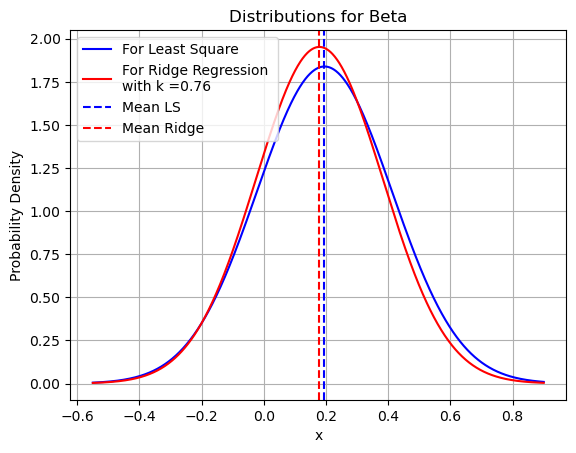

In [237]:
plot_beta_distn(beta, betaR, Var_beta, var_betaR, k)

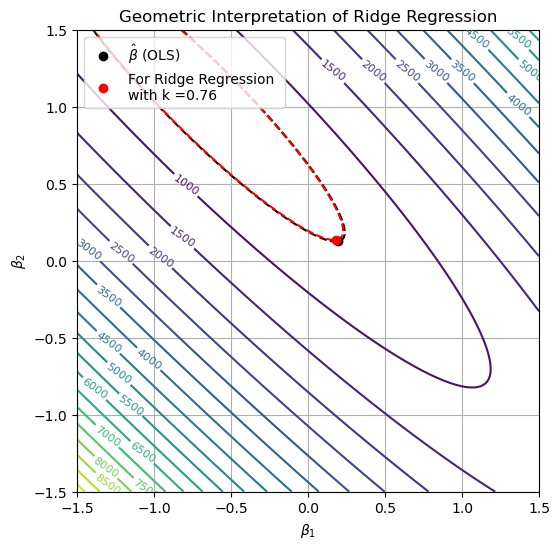

In [238]:
plot_contour(beta, betaR, k, X, y)

**Method 2 - McDonald and Galarneau Method**

This method proposes selecting $\lambda$ such that:

$$
\beta_\lambda^\top \beta_\lambda = \beta^\top \beta - \sigma^2 \sum_{j=1}^{p} \frac{1}{\lambda_j}
$$

where:

- $\beta_\lambda$ is the ridge estimator,  
- $\lambda_j$ are the eigenvalues of $\mathbf{X}^\top \mathbf{X}$,  
- $\sigma^2$ is the OLS estimate of noise variance.
**

In [239]:
lambda_ = np.linalg.eigvals(X.T @ X)    
sigma2 = np.var(y)
sum = 0
for lamb in lambda_:
    sum += 1/(lamb)
rhs = beta.T @ beta - sigma2 * sum
rhs

13.916904171144125

In [240]:
def beta_ridge(k, X=X, y=y):
    return np.linalg.inv(X.T @ X + k* np.eye(X.shape[1])) @ X.T @ y

In [241]:
def f(k,rhs):
    beta = beta_ridge(k)
    return beta.T @ beta - rhs

def f_prime(k, X, y):
    A = X.T @ X + k * np.eye(X.shape[1])
    A_inv = np.linalg.inv(A)
    b = X.T @ y
    beta = A_inv @ b
    return -2 * beta.T @ A_inv @ beta

def newton_raphson(X, y, rhs, k0=1.0, tol=1e-6, max_iter=100):
    k = k0
    for i in range(max_iter):
        fk = f(k,rhs)
        dfk = f_prime(k, X, y)
        if abs(fk) < tol:
            print(f"Converged at iteration {i}")
            return k
        k = k - fk / dfk
    raise ValueError("Did not converge")

k_solution = newton_raphson(X, y, rhs)
print(f"Optimal k: {k_solution}")

Converged at iteration 3
Optimal k: 0.3617059761064228


In [242]:
y_hat = X @ beta_ridge(k_solution).values
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2_scoreR = 1 - (ss_res / ss_tot)
print(f"R² Score: {r2_scoreR}")
r2_ridge["Equation2"] = r2_scoreR

R² Score: 0.8154428504757993


In [ ]:
ridge_inv = np.linalg.inv(XtX + k_solution * I)
var_betaR = np.var(y) * ridge_inv @ XtX @ ridge_inv
print("trace:",np.trace(var_betaR))
print("frobenius norm:",frobenius_norm(var_betaR))
var_betaR = np.diag(var_betaR)

In [244]:
var_ridge["Equation2"] = var_betaR
var_ridge

{'Equation1': array([0.04174631, 0.02424479, 0.00813247, 0.11574676, 0.12373138,
        0.01686154, 0.01591333, 0.00876102, 0.03174732, 0.01293603,
        0.00234495]),
 'Equation2': array([0.04428996, 0.02531909, 0.00833135, 0.14499627, 0.1542598 ,
        0.01723586, 0.01846155, 0.00904803, 0.03351899, 0.01334513,
        0.0023748 ])}

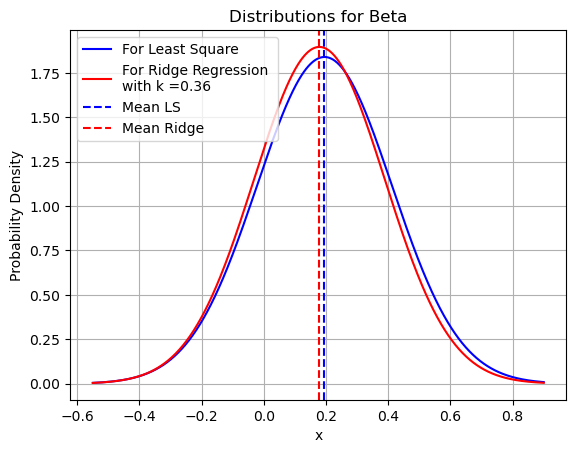

In [245]:
plot_beta_distn(beta, betaR, Var_beta, var_betaR, k_solution)

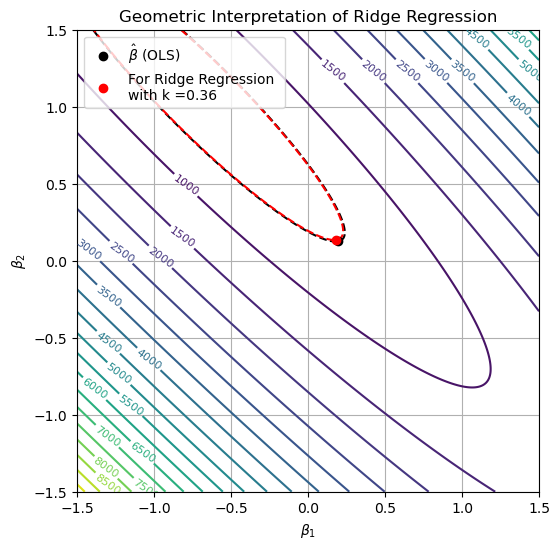

In [246]:
plot_contour(beta, betaR, k_solution, X, y.to_numpy())

### Principal Component Analysis

In [247]:
eigenvalues = np.linalg.eigvals(X.T @ X)
_, eigenvectors = np.linalg.eig(X.T @ X)

In [248]:
T = eigenvectors
Z = X @ T
Lambda = np.diag(eigenvalues)
alpha = T.T @ beta
Z.T @ Z

,0,1,2,3,4,5,6,7,8,9,10
0,7.528260e+03,3.703635e-15,6.394885e-14,2.741807e-12,1.006306e-12,3.754774e-13,9.918177e-13,1.758371e-12,9.336976e-13,-8.211209e-13,7.505108e-13
1,3.703635e-15,7.409413e+02,-6.043343e-14,3.206983e-14,9.421283e-14,-6.307368e-14,2.709050e-13,6.196801e-14,-1.277129e-13,-1.543286e-13,-7.988272e-14
2,6.394885e-14,-6.043343e-14,2.737125e+02,-2.701728e-13,-2.464695e-14,1.442180e-13,9.718615e-14,1.954825e-13,-5.719036e-13,-4.455047e-13,1.174200e-13
3,2.741807e-12,3.206983e-14,-2.701728e-13,1.838944e+02,1.474820e-12,-4.085621e-14,-9.493795e-14,-9.464651e-15,1.343370e-14,1.852546e-13,7.524675e-13
4,1.006306e-12,9.421283e-14,-2.464695e-14,1.474820e-12,1.544640e+02,-2.735034e-13,-1.094125e-13,-3.229361e-13,8.992806e-15,-9.861556e-14,-2.211287e-13
5,3.754774e-13,-6.307368e-14,1.442180e-13,-4.085621e-14,-2.735034e-13,7.708418e+01,-2.168959e-13,-2.484124e-13,1.623146e-13,2.501263e-13,-4.391626e-13
6,9.918177e-13,2.709050e-13,9.718615e-14,-9.493795e-14,-1.094125e-13,-2.168959e-13,5.446745e+01,1.625401e-13,-1.106754e-13,6.934418e-13,4.255415e-13
7,1.758371e-12,6.196801e-14,1.954825e-13,-9.464651e-15,-3.229361e-13,-2.484124e-13,1.625401e-13,2.660375e+00,-1.591227e-13,-2.771169e-13,3.230506e-13
8,9.336976e-13,-1.277129e-13,-5.719036e-13,1.343370e-14,8.992806e-15,1.623146e-13,-1.106754e-13,-1.591227e-13,1.634617e+01,3.905348e-13,4.929807e-13
9,-8.211209e-13,-1.543286e-13,-4.455047e-13,1.852546e-13,-9.861556e-14,2.501263e-13,6.934418e-13,-2.771169e-13,3.905348e-13,2.246635e+01,-2.585432e-14


In [249]:
threshold = 1e-3
B = (eigenvalues / np.sum(eigenvalues) >= threshold).astype(int)
alpha_pc = alpha
for i in range(len(alpha)):
    if B[i] == 0:
        alpha_pc[i] = 0
beta_pc = T @ alpha_pc
B

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [250]:
y_cap = X @ beta_pc
ss_res = np.sum((y - y_cap) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2_score = 1 - (ss_res / ss_tot)
print(f"R² Score: {r2_score:.4f}")

R² Score: 0.8136


In [251]:
Z.head(3) #principal Components and 7 is not significant enough

,0,1,2,3,4,5,6,7,8,9,10
0,-0.602555,0.619371,-0.617615,-0.410342,0.472256,0.141902,-0.173871,0.163431,-0.113173,-0.036208,-0.105683
1,0.850049,0.421434,-0.227668,-0.334667,0.554984,0.087001,-0.536349,0.169611,-0.237635,0.122829,-0.020038
2,0.342425,0.817240,-0.828170,-0.652902,0.316537,0.205245,-0.557232,0.084977,-0.219071,0.103727,0.225868
